In [ ]:
#default_exp lightning.core

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from typing import Optional, Callable
import albumentations as A
import pandas as pd
import wandb

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.metrics.functional.classification import accuracy
from pytorch_lightning import _logger as log
from functools import partial

from src.core import *
from src.layers import *
from src.mixmethods import *

In [ ]:
import timm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#export
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

In [ ]:
#export
class CassavaLightningDataModule(pl.LightningDataModule):
    "lightning-datamodule for cassave leaf disease classification"
    def __init__(self, df_path:str, im_dir:str, curr_fold: int,
                 train_augs: A.Compose, valid_augs: A.Compose, bs: int = 64, 
                 num_workers: int=0):
        
        super().__init__()
        self.df = load_dataset(df_path, im_dir, curr_fold, True)
        self.curr_fold = curr_fold
        self.train_augs, self.valid_augs = train_augs, valid_augs
        self.bs, self.workers = bs, num_workers
    
    def prepare_data(self):
        log.info(f'Generating data for fold: {self.curr_fold}')
        self.train_df: pd.DataFrame = self.df.loc[self.df['is_valid'] == False]
        self.valid_df: pd.DataFrame = self.df.loc[self.df['is_valid'] == True]
            
        self.train_df = self.train_df.reset_index(inplace=False, drop=True)
        self.valid_df = self.valid_df.reset_index(inplace=False, drop=True)
            
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_ds = ImageClassificationFromDf(self.train_df, self.train_augs)
            self.valid_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)
        if stage == "test" or stage is None:
            self.test_ds  = ImageClassificationFromDf(self.valid_df, self.valid_augs)
            
    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.bs, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.bs, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs, num_workers=self.workers)

In [ ]:
def make_show_grid(dl):
    im, batch = next(iter(dl))
    grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(grid);

In [ ]:
#export
class LightningCassava(pl.LightningModule):
    """LightningModule wrapper for `TransferLearningModel`"""
    def __init__(self, 
                 model: TransferLearningModel = None, 
                 opt_func: Callable = None,
                 lr: float = 1e-03,
                 lr_mult: int = 100,
                 step_after: Optional[str] = None, 
                 frequency: int = 1, 
                 metric_to_track: Optional[str] = None,
                 scheduler: Optional[Callable] = None,
                 loss_func: Callable = LabelSmoothingCrossEntropy(), 
                 mixmethod: Optional[Callable] = None):
        
        super().__init__()
        self.model = model
        
        if isinstance(mixmethod, partial): self.mix_fn = mixmethod()
        else                             : self.mix_fn = mixmethod
        
        self.save_hyperparameters()
        
        # remove model from hparams as file becomes too large
        self.hparams.pop('model')
        
        log.info(f'Using {mixmethod}')
        log.info(f'Uses {loss_func}')
        
        self.metrics_to_log= ['train/loss', 'train/acc', 
                              'valid/loss', 'valid/acc', 
                              'test/acc', 'valid/acc']
        
        self.val_labels_list = []
        self.val_preds_list  = []
        
    def forward(self, xb):  
        return self.model(xb)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        if self.mix_fn is not None:
            x = self.mix_fn(x, y, self.model)
            y_hat = self(x)
            loss = self.mix_fn.loss(self.hparams.loss_func, y_hat)
        
        else:
            y_hat = self(x)
            loss = self.hparams.loss_func(y_hat, y)
        
        self.one_batch_of_image = x
            
        train_acc = accuracy(torch.argmax(y_hat, dim=1), y)
            
        self.log('train/loss', loss, on_epoch=True)
        self.log('train/acc',  train_acc, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y  = batch
        y_hat = self(x)
        loss  = self.hparams.loss_func(y_hat, y)
        
        preds = torch.argmax(y_hat, dim=1)
        acc   = accuracy(preds, y)
        
        val_labels = y.data.cpu().numpy()
        val_preds  = preds.data.cpu().numpy()
        
        self.val_preds_list  = self.val_preds_list + list(val_preds)
        self.val_labels_list = self.val_labels_list + list(val_labels)
        
        metrics = {'valid/loss': loss, 'valid/acc': acc}
        self.log_dict(metrics, prog_bar=True, logger=True,)
        return metrics
    
    def test_step(self, batch, batch_idx):
        metrics = self.validation_step(batch, batch_idx)
        metrics = {'test/acc': metrics['valid/acc'], 'test/loss': metrics['valid/loss']}
        self.log_dict(metrics, on_step=False, on_epoch=True)
        
    def configure_optimizers(self):
        ps = self.param_list
        
        try  :
            param_list = [{'params': ps[0], 'lr': self.hparams.lr/self.hparams.lr_mult},
                          {'params': ps[1], 'lr': self.hparams.lr},
                          {'params': ps[2], 'lr': self.hparams.lr}]
        
        except:
            param_list = [{'params': ps[0], 'lr': self.hparams.lr/self.hparams.lr_mult},
                          {'params': ps[1], 'lr': self.hparams.lr}]
        
        opt_func = self.hparams.opt_func
        
        try   : log.info(f'Using {opt_func}')
        except: pass
        
        opt = opt_func(param_list)
        
        if self.hparams.scheduler is not None:
            sch_func = self.hparams.scheduler
            
            try   : log.info(f'Using {sch_func}')
            except: pass
            
            try:
                # for OneCycleLR set the LR so we can use LrFinder
                lr_list = [self.hparams.lr/self.hparams.lr_mult, self.hparams.lr]
                sch = sch_func(opt, max_lr=lr_list, steps_per_epoch=len(self.train_dataloader()))
            except: sch = sch_func(opt)
                
            # convert scheduler to lightning format
            sch = {'scheduler': sch, 
                   'monitor'  : self.hparams.metric_to_track, 
                   'interval' : self.hparams.step_after, 
                   'frequency': self.hparams.frequency}
            
            return [opt], [sch]
        
        else: return [opt]
        
    @property
    def param_list(self):
        try   : param_list = [params(self.model.encoder), params(self.model.fc), params(self.model.mcls)]
        except: param_list = [params(self.model.encoder), params(self.model.fc)] 
        return param_list
    
    def save_model_weights(self, path:str):
        state = self.model.state_dict()
        torch.save(state, path)
        log.info(f'weights saved to {path}')
        
    def load_model_weights(self, path:str):
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict)
        log.info(f'weights loaded from {path}')

In [ ]:
#export
class WandbImageClassificationCallback(pl.Callback):
    """ Custom callback to add some extra functionalites to the wandb logger """
    
    def __init__(self, dm: CassavaLightningDataModule, num_log_train_batchs: int = 1):
        # class names for the confusion matrix
        self.class_names = list(idx2lbl.values())
        
        # counter to log training batch images
        self.num_batch = 0
        self.counter   = num_log_train_batchs - 1
        self.dm = dm
    
    def on_train_start(self, trainer, pl_module: LightningCassava):
        # log model to the wandb experiment
        wandb.watch(models=pl_module.model, criterion=pl_module.hparams.loss_func)
        
        keywords = pl_module.hparams['opt_func'].keywords
        mm       = pl_module.hparams['mixmethod']
        
        # overrride defaults log hparams to make run more meaningfull
        config_defaults = {}
        config_defaults['num_epochs']    = trainer.max_epochs
        config_defaults['num_classes']   = len(idx2lbl)
        config_defaults['loss_func']     = pl_module.hparams['loss_func'].__class__.__name__
        config_defaults['scheduler']     = pl_module.hparams['scheduler'].func.__name__
        config_defaults['opt_func']      = pl_module.hparams['opt_func'].func.__name__
        config_defaults['lr']            = pl_module.hparams['lr']
        config_defaults['lr_mult']       = pl_module.hparams['lr_mult']
        config_defaults['learning_rate'] = pl_module.hparams['lr']
        config_defaults['weight_decay']  = keywords['weight_decay']
        config_defaults['model']         = pl_module.model.encoder_class_name
        
        if isinstance(mm, partial): mm   = mm.func.__name__
        else                      : mm   = mm.__class__.__name__
        
        config_defaults['mixmethod']     = mm
        
        train_tfms = list(self.dm.train_augs.transforms)
        valid_tfms = list(self.dm.valid_augs.transforms)
        
        config_defaults['train_tfms'] = train_tfms
        config_defaults['valid_tfms'] = valid_tfms
        config_defaults['callbacks']  = [cb.__class__.__name__ for cb in trainer.callbacks]
        
        pl_module.logger.log_hyperparams(config_defaults)
        
    def on_train_batch_end(self, trainer, pl_module: LightningCassava, *args, **kwargs):
        if self.num_batch == self.counter:
            # log the training images for the 1st batch
            train_ims = pl_module.one_batch_of_image
            train_ims = train_ims.to('cpu')
            trainer.logger.experiment.log({"train_batch": [wandb.Image(x) for x in train_ims]})
            self.num_batch += 1
            
    def on_epoch_start(self, trainer, pl_module: LightningCassava, *args, **kwargs):
        pl_module.val_labels_list = []
        pl_module.val_preds_list  = []
    
    def on_epoch_end(self, trainer, pl_module: LightningCassava, *args, **kwargs):
        val_preds  = torch.tensor(pl_module.val_preds_list).data.cpu().numpy()
        val_labels = torch.tensor(pl_module.val_labels_list).data.cpu().numpy()
        
        # Log confusion matrix
        wandb.log({'conf_mat': wandb.plot.confusion_matrix(val_preds,val_labels,self.class_names)})
        

In [ ]:
train_augs = A.Compose([
    A.RandomResizedCrop(224, 224, p=1.0),
    A.RandomBrightness(),
    A.HorizontalFlip(),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

valid_augs = A.Compose([
    A.Resize(224, 224, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

csv = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
ims = "../../Datasets/cassava/train_images/"
dm = CassavaLightningDataModule(csv, ims, curr_fold=0, train_augs=train_augs, 
                                valid_augs=valid_augs, bs=32, num_workers=0)
dm.prepare_data()
dm.setup()
train_dl,valid_dl,test_dl = dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()

Generating data for fold: 0


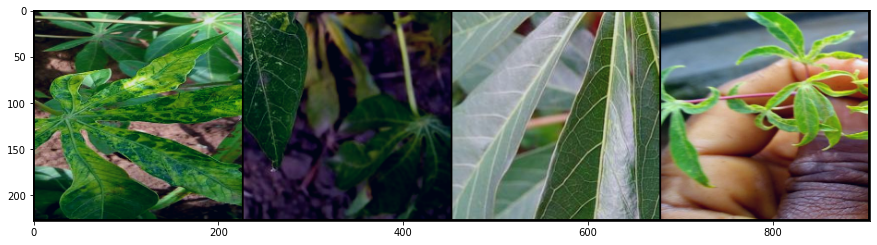

In [ ]:
make_show_grid(train_dl)

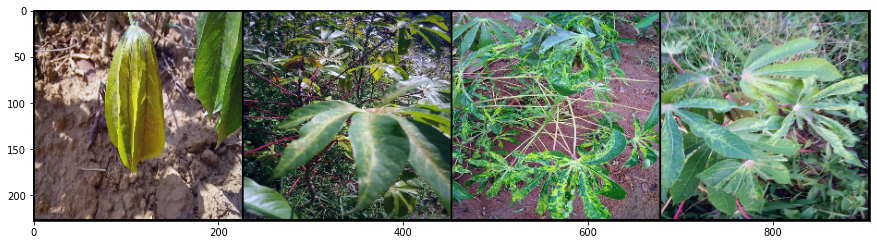

In [ ]:
make_show_grid(valid_dl)

In [ ]:
encoder = timm.create_model('resnet18', pretrained=False)
model = SnapMixTransferLearningModel(encoder, cut=-2, c=5, act=nn.ReLU(inplace=True))
wandb_logger = pl.loggers.WandbLogger(project='kaggle-leaf-disease-fastai-runs', name='lit_test_dev')

model = LightningCassava(model=model, lr=1e-02, lr_mult=100, step_after='step',
                opt_func=partial(torch.optim.AdamW, weight_decay=0.01, eps=1e-05),
                scheduler=partial(torch.optim.lr_scheduler.OneCycleLR, epochs=3), 
                mixmethod=partial(SnapMix, alpha=0.5, conf_prob=1.0), 
                loss_func=LabelSmoothingCrossEntropy(0.1))

callback_list = [pl.callbacks.LearningRateMonitor('step'), WandbImageClassificationCallback(dm)]

trainer = pl.Trainer(callbacks=callback_list, log_every_n_steps=10,
                    logger=wandb_logger, max_epochs=3, num_sanity_val_steps=0, 
                    gradient_clip_val=0.1, limit_train_batches=0.05, limit_val_batches=0.2, 
                    limit_test_batches=0.2,)

Using functools.partial(<class 'src.mixmethods.SnapMix'>, alpha=0.5, conf_prob=1.0)
Uses LabelSmoothingCrossEntropy()
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [ ]:
len(model.param_list)

3

In [ ]:
# lr_finder = trainer.tuner.lr_find(model, datamodule=dm)
# fig = lr_finder.plot(suggest=True)
# fig.show()

In [ ]:
# update hparams of the model
model.hparams.lr = 2e-03
trainer.fit(model, datamodule=dm)

Using functools.partial(<class 'torch.optim.adamw.AdamW'>, weight_decay=0.01, eps=1e-05)
Using functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, epochs=3)
wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name  | Type                  | Params
------------------------------------------------
0 | model | TransferLearningModel | 12.2 M


1

In [ ]:
res = trainer.test()

Using functools.partial(<class 'torch.optim.adamw.AdamW'>, weight_decay=0.01, eps=1e-05)
Using functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, epochs=3)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': tensor(0.6178),
 'test/loss': tensor(1.2515),
 'train/acc': tensor(0.5625),
 'train/loss': tensor(1.8051),
 'valid/acc': tensor(0.6178),
 'valid/loss': tensor(1.2515)}
--------------------------------------------------------------------------------



In [ ]:
model.save_model_weights("example.pt")

weights saved to example.pt


In [ ]:
model.load_model_weights('example.pt')

weights loaded from example.pt
